# 정적 자산배분

자산 배분은 크게 두가지로 나뉜다.

정적 자산배분, 동적 자산배분.  

정적 자산배분은 주식:채권 = 1:1처럼 한번 정한 비율을 계속해서 유지하여 투자하는 방법
동적 자산배분은 모멘텀 기법처럼 장세에 맞춰서 종목 비중을 조절하며 투자하는 방법이다.

* 올웨더 포트폴리오
* 영구포트폴리오 -> LAA
* 황금나비

### 데이터 준비하기
- 미국주식 VTI
- 미국 소형가치주 VBR (찾자 또는 대안 IJS) 
- 장기채 미 20년물 TLT
- 중장기채 미 7-10년물 IEF
- 중기채 미 3-7년물 IEI
- 단기채 미 1-3년물 SHY
- 원자재 GSG
- 금 GLD

In [2]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet=None):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
        
#     # 자산별 비중이 반영된 개별자산 누적 수익률
#     weightedCumulativeReturn = weight * cumulativeReturn
#     # 자산흐름 정규화: 시기별 각 자산 보유 비율
#     normalizedAssetFlow = weightedCumulativeReturn.divide(weightedCumulativeReturn.sum(axis=1), axis=0) # 각 행의 합으로 각 행을 나누기
#     # 자산별 비중이 반영된 개별자산 일별 수익률
#     weightedDayReturn = normalizedAssetFlow * dayReturn.shift(-1).fillna(0)
#     # 포트폴리오 일별 수익률 = 자산별 비중이 반영된 개별자산 일별 수익률의 합
#     portfolioDayReturn = weightedDayReturn.sum(axis=1).shift(1).fillna(1)
#     # 포트폴리오 누적 수익률
#     portfolioCumulativeReturn = portfolioDayReturn.cumprod()
# #     portfolioCumulativeReturn = weightedCumulativeReturn.sum(axis=1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"cagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
    
    # 만약, weightDf에 모든 종목이 0으로 잡히는 구간이 있다면
    noWeight = weightDf.sum(axis=1) == 0
    if not weightDf.loc[noWeight].empty :
        # weightDf에 모든 종목이 0인 구간에서는 cash 컬럼을 추가하여 1로 설정한다.
        weightDf['cash'] = np.where(noWeight, 1, 0)
        # 첫 투자 비중은 현금을 제외한 동일비중
        firstWeight = [1/(len(weightDf.columns)-1)] * len(weightDf.columns)
        firstWeight[-1] = 0
        weightDf.iloc[0] =  firstWeight
        # closeDataSet에 cash컬럼을 추가하여 1로 설정한다.
        closeDataSet['cash'] = 1
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getAvgMomentum(closeDataSet, n=12):
    """
    평균 모멘텀 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 평균 모멘텀 df
    """
    n = 12
    avgMomentum = 0 # 초기값
    dataSetOnRebalancingDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] 
    
    # 1~n개월 모멘텀 합 계산
    for i in range(1, n+1): 
        avgMomentum = dataSetOnRebalancingDate / dataSetOnRebalancingDate.shift(i) + avgMomentum
        
    avgMomentum = pd.DataFrame(avgMomentum) # dataframe으로 변환
    avgMomentum = (avgMomentum / 12).fillna(0) # 평균화
    return avgMomentum

def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 초기값
    dataSetOnRebalancingDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] 
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(dataSetOnRebalancingDate / dataSetOnRebalancingDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=dataSetOnRebalancingDate.index, columns=dataSetOnRebalancingDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / 12 # 평균화
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0) # 모멘텀 스코어에 따른 weight 계산
    return weight, avgMomentumScore

## 데이터 로드

In [4]:
tickers = ["VTI", "TLT", "IEF", "IEI", "SHY", "GSG", "GLD"]

In [5]:
closeDataSet = pd.read_csv("./정적자산배분데이터.csv", index_col=0, parse_dates=True)
closeDataSet

,VTI,VBR,TLT,IEF,IEI,SHY,GSG,GLD
2010-01-04,46.08189,55.52,66.13332,71.24535,94.21502,75.39010,32.70,109.80
2010-01-05,46.25879,55.46,66.56042,71.55817,94.51414,75.48085,33.03,109.70
2010-01-06,46.32312,55.55,65.66942,71.26941,94.38595,75.48993,33.27,111.51
2010-01-07,46.51610,56.04,65.77987,71.26941,94.35176,75.47178,33.11,110.82
2010-01-08,46.66887,56.24,65.75042,71.35764,94.48850,75.54438,33.18,111.37
...,...,...,...,...,...,...,...,...
2022-06-16,183.02000,146.67,111.72000,100.17000,117.71000,82.40000,25.41,172.69
2022-06-17,183.71000,147.45,112.08000,100.20000,117.60000,82.38000,24.50,171.27
2022-06-21,188.16000,149.69,110.18000,99.68000,117.35000,82.35000,24.48,170.63
2022-06-22,188.13000,149.04,113.21000,100.94000,118.26000,82.59000,24.01,171.31


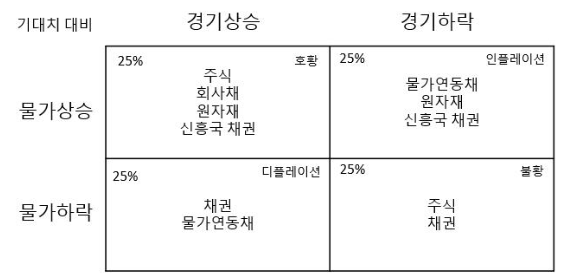

## 올웨더 포트폴리오

사계절 포트폴리오라고도 불리는데, 시장의 모든 상황에 대비할 수 있는 정적자산배분 투자법이다.  


---

투자전략  

주식: 30%,  미국전체주식(VTI)  
장기 채권 40%, 미 20년물 (TLT)  
중기 채권 15%, 미 3-7년물 (IEI)  
원자재 7.5%, (GSG)  
금 7.5%  (GLD)  
월별 / 분기별 / 연별 리밸런싱

In [73]:
# 데이터 준비
allWeatherCol = ['VTI', "TLT", "IEI", "GSG", "GLD"]
allWeatherData = closeDataSet[allWeatherCol]
allWeatherData

,VTI,TLT,IEI,GSG,GLD
2010-01-04,46.08189,66.13332,94.21502,32.70,109.80
2010-01-05,46.25879,66.56042,94.51414,33.03,109.70
2010-01-06,46.32312,65.66942,94.38595,33.27,111.51
2010-01-07,46.51610,65.77987,94.35176,33.11,110.82
2010-01-08,46.66887,65.75042,94.48850,33.18,111.37
...,...,...,...,...,...
2022-06-07,208.69000,115.12000,119.36000,26.13,172.94
2022-06-08,206.35000,114.10000,119.15000,26.34,172.78
2022-06-09,201.41000,114.48000,119.01000,26.28,172.23
2022-06-10,195.43000,113.77000,118.04000,26.00,174.54


In [74]:
# 올웨더 weightDf 만들기
rebalDate = getRebalancingDate(closeDataSet)
allWeatherWeight = [0.3, 0.4, 0.15, 0.075, 0.075]
allWeatherWeightDf = pd.DataFrame([allWeatherWeight] * len(rebalDate))
allWeatherWeightDf.index = rebalDate
allWeatherWeightDf.columns = allWeatherCol
allWeatherWeightDf

,VTI,TLT,IEI,GSG,GLD
2010-01-29,0.3,0.4,0.15,0.075,0.075
2010-02-26,0.3,0.4,0.15,0.075,0.075
2010-03-31,0.3,0.4,0.15,0.075,0.075
2010-04-30,0.3,0.4,0.15,0.075,0.075
2010-05-28,0.3,0.4,0.15,0.075,0.075
...,...,...,...,...,...
2022-02-28,0.3,0.4,0.15,0.075,0.075
2022-03-31,0.3,0.4,0.15,0.075,0.075
2022-04-29,0.3,0.4,0.15,0.075,0.075
2022-05-31,0.3,0.4,0.15,0.075,0.075


In [75]:
allWeatherDayReturn, allWeatherCumReturn = getRebalancingPortfolioResult(allWeatherData, allWeatherWeightDf)
getEvaluation(allWeatherCumReturn)

cagr: 1.0650267709264742
mdd: 16.958068365700633


(1.0650267709264742,
 2010-01-29     0.000000
 2010-02-01     0.000000
 2010-02-02     0.000000
 2010-02-03     0.698357
 2010-02-04     1.562669
                 ...    
 2022-06-07    12.275218
 2022-06-08    12.853895
 2022-06-09    13.420986
 2022-06-10    14.486828
 2022-06-13    16.958068
 Length: 3115, dtype: float64,
 16.958068365700633)

In [76]:
allWeatherCumReturn.iloc[-1]

2.178745401482244

## 영구 포트폴리오

올웨더와 마찬가지로 모든 경제상황에서도 변동성을 잘 견디도록 만들어진 정적자산배분 투자법이다.

---

투자전략

주식: 25%, (VTI)  
채권 25%, (TLT)  
현금 또는 단기채 25%,  미 단기 채권 (SHY)  
금 25%  (GLD)  
월별 / 분기별 / 연별 리밸런싱

In [77]:
# 데이터 준비
perCol = ['VTI', "TLT", "SHY", "GLD"]
perData = closeDataSet[perCol]
perData

,VTI,TLT,SHY,GLD
2010-01-04,46.08189,66.13332,75.39010,109.80
2010-01-05,46.25879,66.56042,75.48085,109.70
2010-01-06,46.32312,65.66942,75.48993,111.51
2010-01-07,46.51610,65.77987,75.47178,110.82
2010-01-08,46.66887,65.75042,75.54438,111.37
...,...,...,...,...
2022-06-07,208.69000,115.12000,83.02000,172.94
2022-06-08,206.35000,114.10000,82.96000,172.78
2022-06-09,201.41000,114.48000,82.90000,172.23
2022-06-10,195.43000,113.77000,82.55000,174.54


In [78]:
# 영구 weightDf 만들기
rebalDate = getRebalancingDate(closeDataSet)
perWeight = [0.25, 0.25, 0.25, 0.25]
perWeightDf = pd.DataFrame([perWeight] * len(rebalDate))
perWeightDf.index = rebalDate
perWeightDf.columns = perCol
perWeightDf

,VTI,TLT,SHY,GLD
2010-01-29,0.25,0.25,0.25,0.25
2010-02-26,0.25,0.25,0.25,0.25
2010-03-31,0.25,0.25,0.25,0.25
2010-04-30,0.25,0.25,0.25,0.25
2010-05-28,0.25,0.25,0.25,0.25
...,...,...,...,...
2022-02-28,0.25,0.25,0.25,0.25
2022-03-31,0.25,0.25,0.25,0.25
2022-04-29,0.25,0.25,0.25,0.25
2022-05-31,0.25,0.25,0.25,0.25


In [79]:
perDayReturn, perCumReturn = getRebalancingPortfolioResult(perData, perWeightDf)
getEvaluation(perCumReturn)

cagr: 1.057976318508955
mdd: 14.150393310423546


(1.057976318508955,
 2010-01-29     0.000000
 2010-02-01     0.000000
 2010-02-02     0.000000
 2010-02-03     0.529430
 2010-02-04     1.904337
                 ...    
 2022-06-07    10.265686
 2022-06-08    10.752836
 2022-06-09    11.304218
 2022-06-10    11.881566
 2022-06-13    14.150393
 Length: 3115, dtype: float64,
 14.150393310423546)

In [80]:
perCumReturn.iloc[-1]

2.0070116630874093

<AxesSubplot:>

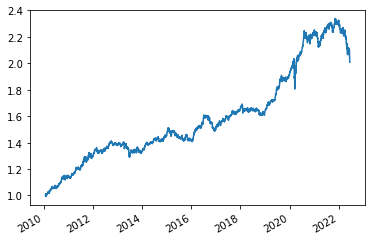

In [81]:
perCumReturn.plot()

## 황금나비 포트폴리오

영구 포트폴리오의 주식 비중이 25% 밖에 되지 않는다는 점을 보완하는 포트폴리오

---

투자전략

주식: 20%, (VTI)  
소형가치주 20%  미국 소형가치주 (VBR)  
채권 20%, (TLT)  
현금 또는 단기채 20%, (SHY)  
금 20%  (GLD)  
월별 / 분기별 / 연별 리밸런싱

In [82]:
# 데이터 준비
flyCol = ['VTI', "VBR", "TLT", "SHY", "GLD"]
flyData = closeDataSet[flyCol]
flyData

,VTI,VBR,TLT,SHY,GLD
2010-01-04,46.08189,55.52,66.13332,75.39010,109.80
2010-01-05,46.25879,55.46,66.56042,75.48085,109.70
2010-01-06,46.32312,55.55,65.66942,75.48993,111.51
2010-01-07,46.51610,56.04,65.77987,75.47178,110.82
2010-01-08,46.66887,56.24,65.75042,75.54438,111.37
...,...,...,...,...,...
2022-06-07,208.69000,171.59,115.12000,83.02000,172.94
2022-06-08,206.35000,168.52,114.10000,82.96000,172.78
2022-06-09,201.41000,164.87,114.48000,82.90000,172.23
2022-06-10,195.43000,160.45,113.77000,82.55000,174.54


In [83]:
# 영구 weightDf 만들기
rebalDate = getRebalancingDate(closeDataSet)
flyWeight = [0.2] * 5
flyWeightDf = pd.DataFrame([flyWeight] * len(rebalDate))
flyWeightDf.index = rebalDate
flyWeightDf.columns = flyCol
flyWeightDf

,VTI,VBR,TLT,SHY,GLD
2010-01-29,0.2,0.2,0.2,0.2,0.2
2010-02-26,0.2,0.2,0.2,0.2,0.2
2010-03-31,0.2,0.2,0.2,0.2,0.2
2010-04-30,0.2,0.2,0.2,0.2,0.2
2010-05-28,0.2,0.2,0.2,0.2,0.2
...,...,...,...,...,...
2022-02-28,0.2,0.2,0.2,0.2,0.2
2022-03-31,0.2,0.2,0.2,0.2,0.2
2022-04-29,0.2,0.2,0.2,0.2,0.2
2022-05-31,0.2,0.2,0.2,0.2,0.2


In [84]:
flyDayReturn, flyCumReturn = getRebalancingPortfolioResult(flyData, flyWeightDf)
getEvaluation(flyCumReturn)

cagr: 1.066870964506567
mdd: 17.283522817123437


(1.066870964506567,
 2010-01-29     0.000000
 2010-02-01     0.000000
 2010-02-02     0.000000
 2010-02-03     0.582849
 2010-02-04     2.339999
                 ...    
 2022-06-07     9.677349
 2022-06-08    10.396559
 2022-06-09    11.229352
 2022-06-10    12.165373
 2022-06-13    14.790647
 Length: 3115, dtype: float64,
 17.283522817123437)

In [85]:
flyCumReturn.iloc[-1]

2.2258416595891344

<AxesSubplot:>

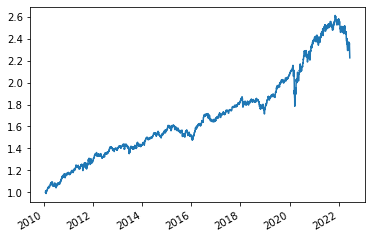

In [86]:
flyCumReturn.plot()

### 벤치마크 지수와 비교

In [87]:
vtiCumReturn = getCumulativeReturn(closeDataSet['VTI'])
getEvaluation(vtiCumReturn)

cagr: 1.1194712050179985
mdd: 35.00027962575364


(1.1194712050179985,
 2010-01-04     0.000000
 2010-01-05     0.000000
 2010-01-06     0.000000
 2010-01-07     0.000000
 2010-01-08     0.000000
                 ...    
 2022-06-07    14.108738
 2022-06-08    15.071820
 2022-06-09    17.104992
 2022-06-10    19.566202
 2022-06-13    22.850558
 Name: VTI, Length: 3133, dtype: float64,
 35.00027962575364)

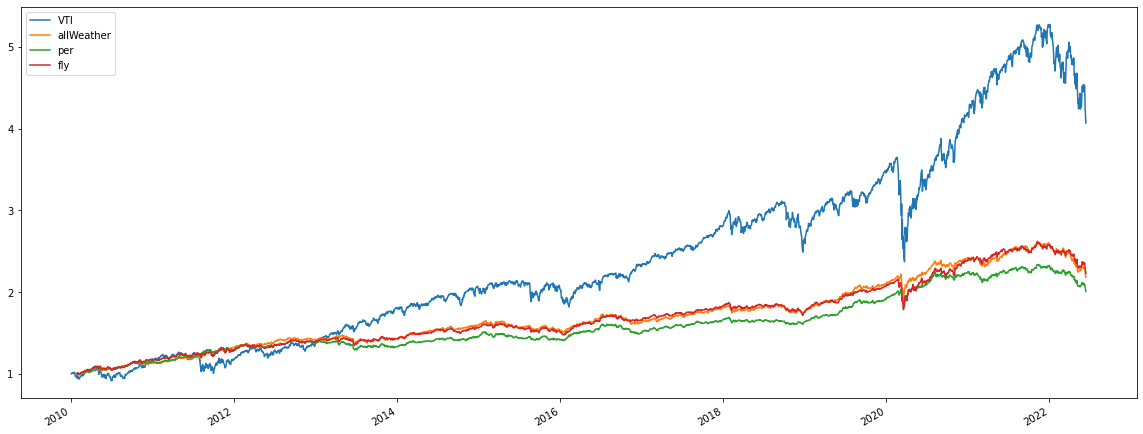

In [88]:
plt.figure(figsize=(20, 8))
vtiCumReturn.plot(label="VTI")
allWeatherCumReturn.plot(label="allWeather")
perCumReturn.plot(label="per")
flyCumReturn.plot(label="fly")
plt.legend()
plt.show()

### 리밸런싱 주기 수정

In [89]:
def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

In [99]:
def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

### 분기별 리밸런싱

In [100]:
rebalDate = getRebalancingDate(closeDataSet, "quarter")

# 올웨더
allWeatherWeight = [0.3, 0.4, 0.15, 0.075, 0.075]
allWeatherWeightDf = pd.DataFrame([allWeatherWeight] * len(rebalDate))
allWeatherWeightDf.index = rebalDate
allWeatherWeightDf.columns = allWeatherCol
allWeatherDayReturn, allWeatherCumReturn = getRebalancingPortfolioResult(allWeatherData, period="quarter", weightDf=allWeatherWeightDf)
getEvaluation(allWeatherCumReturn)

# 영구
perWeight = [0.25, 0.25, 0.25, 0.25]
perWeightDf = pd.DataFrame([perWeight] * len(rebalDate))
perWeightDf.index = rebalDate
perWeightDf.columns = perCol
perDayReturn, perCumReturn = getRebalancingPortfolioResult(perData, period="quarter", weightDf=perWeightDf)
getEvaluation(perCumReturn)

# 황금나비
flyWeight = [0.2] * 5
flyWeightDf = pd.DataFrame([flyWeight] * len(rebalDate))
flyWeightDf.index = rebalDate
flyWeightDf.columns = flyCol
flyDayReturn, flyCumReturn = getRebalancingPortfolioResult(flyData, period="quarter", weightDf=flyWeightDf)
getEvaluation(flyCumReturn)

cagr: 1.0668346370617967
mdd: 16.550780122042504
cagr: 1.0579341332644336
mdd: 14.017277511420446
cagr: 1.0660568761481963
mdd: 16.177541165895335


(1.0660568761481963,
 2010-03-31     0.000000
 2010-04-01     0.000000
 2010-04-05     0.000000
 2010-04-06     0.000000
 2010-04-07     0.000000
                 ...    
 2022-06-07     9.671966
 2022-06-08    10.381576
 2022-06-09    11.211368
 2022-06-10    12.133936
 2022-06-13    14.727547
 Length: 3073, dtype: float64,
 16.177541165895335)

### 연별 리밸런싱

In [101]:
rebalDate = getRebalancingDate(closeDataSet, "year")

# 올웨더
allWeatherWeight = [0.3, 0.4, 0.15, 0.075, 0.075]
allWeatherWeightDf = pd.DataFrame([allWeatherWeight] * len(rebalDate))
allWeatherWeightDf.index = rebalDate
allWeatherWeightDf.columns = allWeatherCol
allWeatherDayReturn, allWeatherCumReturn = getRebalancingPortfolioResult(allWeatherData, period="year", weightDf=allWeatherWeightDf)
getEvaluation(allWeatherCumReturn)

# 영구
perWeight = [0.25, 0.25, 0.25, 0.25]
perWeightDf = pd.DataFrame([perWeight] * len(rebalDate))
perWeightDf.index = rebalDate
perWeightDf.columns = perCol
perDayReturn, perCumReturn = getRebalancingPortfolioResult(perData, period="year", weightDf=perWeightDf)
getEvaluation(perCumReturn)

# 황금나비
flyWeight = [0.2] * 5
flyWeightDf = pd.DataFrame([flyWeight] * len(rebalDate))
flyWeightDf.index = rebalDate
flyWeightDf.columns = flyCol
flyDayReturn, flyCumReturn = getRebalancingPortfolioResult(flyData, period="year", weightDf=flyWeightDf)
getEvaluation(flyCumReturn)

cagr: 1.0593846125714657
mdd: 15.694427663078029
cagr: 1.0495718390878217
mdd: 13.717112340587768
cagr: 1.056358688049612
mdd: 16.177541165895345


(1.056358688049612,
 2010-12-31     0.000000
 2011-01-03     0.000000
 2011-01-04     0.757111
 2011-01-05     1.006262
 2011-01-06     1.107367
                 ...    
 2022-06-07     9.566744
 2022-06-08    10.264866
 2022-06-09    11.098074
 2022-06-10    11.983169
 2022-06-13    14.570628
 Length: 2882, dtype: float64,
 16.177541165895345)

#### 리밸런싱 주기가 달라지면 데이터 시작일자도 달라져서 비교가 정확하진 않은데,, 일단 디테일은 나중에 잡고 고

## 정적자산분배 전략에 평균모멘텀스코어를 적용해서 동적 자산배분으로 바꿔본다면?